In [1]:
import torchvision

from src.utils import *
from src.models.gan import *
from src.models.vae import *
from src.models.ae import *
from src.pipeline.base_model import *
from src.pipeline.trainer import *
from src.data.cifar10 import *

import torch
from torch import nn
import piq

In [2]:
cifar10_data_module = CIFAR10DataModule(data_dir='./data', batch_size=64, val_split=0.2)
cifar10_data_module.setup()

print(f"Training set size: {len(cifar10_data_module.train_dataloader().dataset)}")
print(f"Validation set size: {len(cifar10_data_module.val_dataloader().dataset)}")
print(f"Test set size: {len(cifar10_data_module.test_dataloader().dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Validation set size: 10000
Test set size: 10000


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# GAN

In [8]:
class GANModule(BaseModel):
    def __init__(self, latent_dim, lr=2e-04, b1=0.5, b2=0.999):
        super().__init__()
        self.generator = Generator(latent_dim=latent_dim).to(device)
        self.discriminator = Discriminator().to(device)
        self.latent_dim = latent_dim
        self.lr = lr
        self.b1 = b1
        self.b2 = b2

        self.to(self.device)

        self.validation_z = torch.randn(40, *(latent_dim, 1, 1), device=self.device)

    @staticmethod
    def adversarial_loss(y_hat, y):
        return nn.BCELoss()(y_hat, y)

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        return {"generator": opt_g, "discriminator": opt_d}

    def training_step(self, batch, optimizers):
        # Extract optimizers
        optimizer_g = optimizers["generator"]
        optimizer_d = optimizers["discriminator"]

        # Prepare real data and labels
        real_data = batch[0].to(self.device)
        batch_size = real_data.size(0)
        real_labels = torch.ones(batch_size, device=self.device, dtype=torch.float)
        fake_labels = torch.zeros(batch_size, device=self.device, dtype=torch.float)

        # Discriminator training: Real data
        self.discriminator.zero_grad()
        real_output = self.discriminator(real_data)
        d_loss_real = self.adversarial_loss(real_output, real_labels)
        d_loss_real.backward()

        # Discriminator training: Fake data
        noise = torch.randn(batch_size, self.latent_dim, 1, 1, device=self.device, dtype=torch.float)
        fake_data = self.generator(noise)
        fake_output = self.discriminator(fake_data.detach())  # Detach to prevent gradients from affecting the generator
        d_loss_fake = self.adversarial_loss(fake_output, fake_labels)
        d_loss_fake.backward()

        # Update the discriminator
        d_loss_total = d_loss_real + d_loss_fake
        optimizer_d.step()

        # Generator training
        self.generator.zero_grad()
        generator_output = self.discriminator(fake_data)  # No detach; gradients should flow back to the generator
        g_loss = self.adversarial_loss(generator_output, real_labels)  # Use real labels for generator loss
        g_loss.backward()

        # Update the generator
        optimizer_g.step()

        # Return losses and diagnostics
        return {
            "g_loss": g_loss.item(),
            "d_loss": d_loss_total.item(),
            "loss": g_loss.item() + d_loss_total.item()
        }

    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        imgs = imgs.to(self.device)

        z = torch.randn(imgs.shape[0], self.latent_dim, 1, 1, device=self.device)
        generated_imgs = self.generator(z)

        # Validation loss: how well discriminator identifies real vs fake
        valid = torch.ones(imgs.size(0), device=self.device)
        fake = torch.zeros(imgs.size(0), device=self.device)

        real_loss = self.adversarial_loss(self.discriminator(imgs), valid)
        fake_loss = self.adversarial_loss(self.discriminator(generated_imgs), fake)

        val_loss = (real_loss + fake_loss) / 2
        val_output = {"loss": val_loss.item()}

        if batch_idx == 0:
            sampled_imaged = torchvision.utils.make_grid(self.generator(self.validation_z), nrow=8)
            val_output.update({
                "sampling_img": sampled_imaged
            })

        return val_output



In [9]:
gan_model = GANModule(latent_dim=100)

gan_trainer = Trainer(
    model=gan_model,
    data_module=cifar10_data_module,
    log_dir='./tensorboard/gan_logs',
    checkpoint_dir='./tensorboard/gan_checkpoints',
    device=device)

In [10]:
gan_trainer.train(num_epochs=30)

Epoch 0:
	Train Metrics = {'g_loss': 2.1639731950759886, 'd_loss': 1.0787469031095505, 'loss': 3.242720098185539}
	Val Metrics = {'loss': 0.7555780152606356}
	Best model saved at epoch 0 with loss=0.755578
Epoch 0:
	Train Metrics = {'g_loss': 1.678878293800354, 'd_loss': 1.1533279912948609, 'loss': 2.8322062850952148}
	Val Metrics = {'loss': 0.5575758795829335}
	Best model saved at epoch 1 with loss=0.557576
Epoch 1:
	Train Metrics = {'g_loss': 1.4230384989738465, 'd_loss': 1.19217783575058, 'loss': 2.615216334724426}
	Val Metrics = {'loss': 0.6461480620560373}
Epoch 2:


KeyboardInterrupt: 

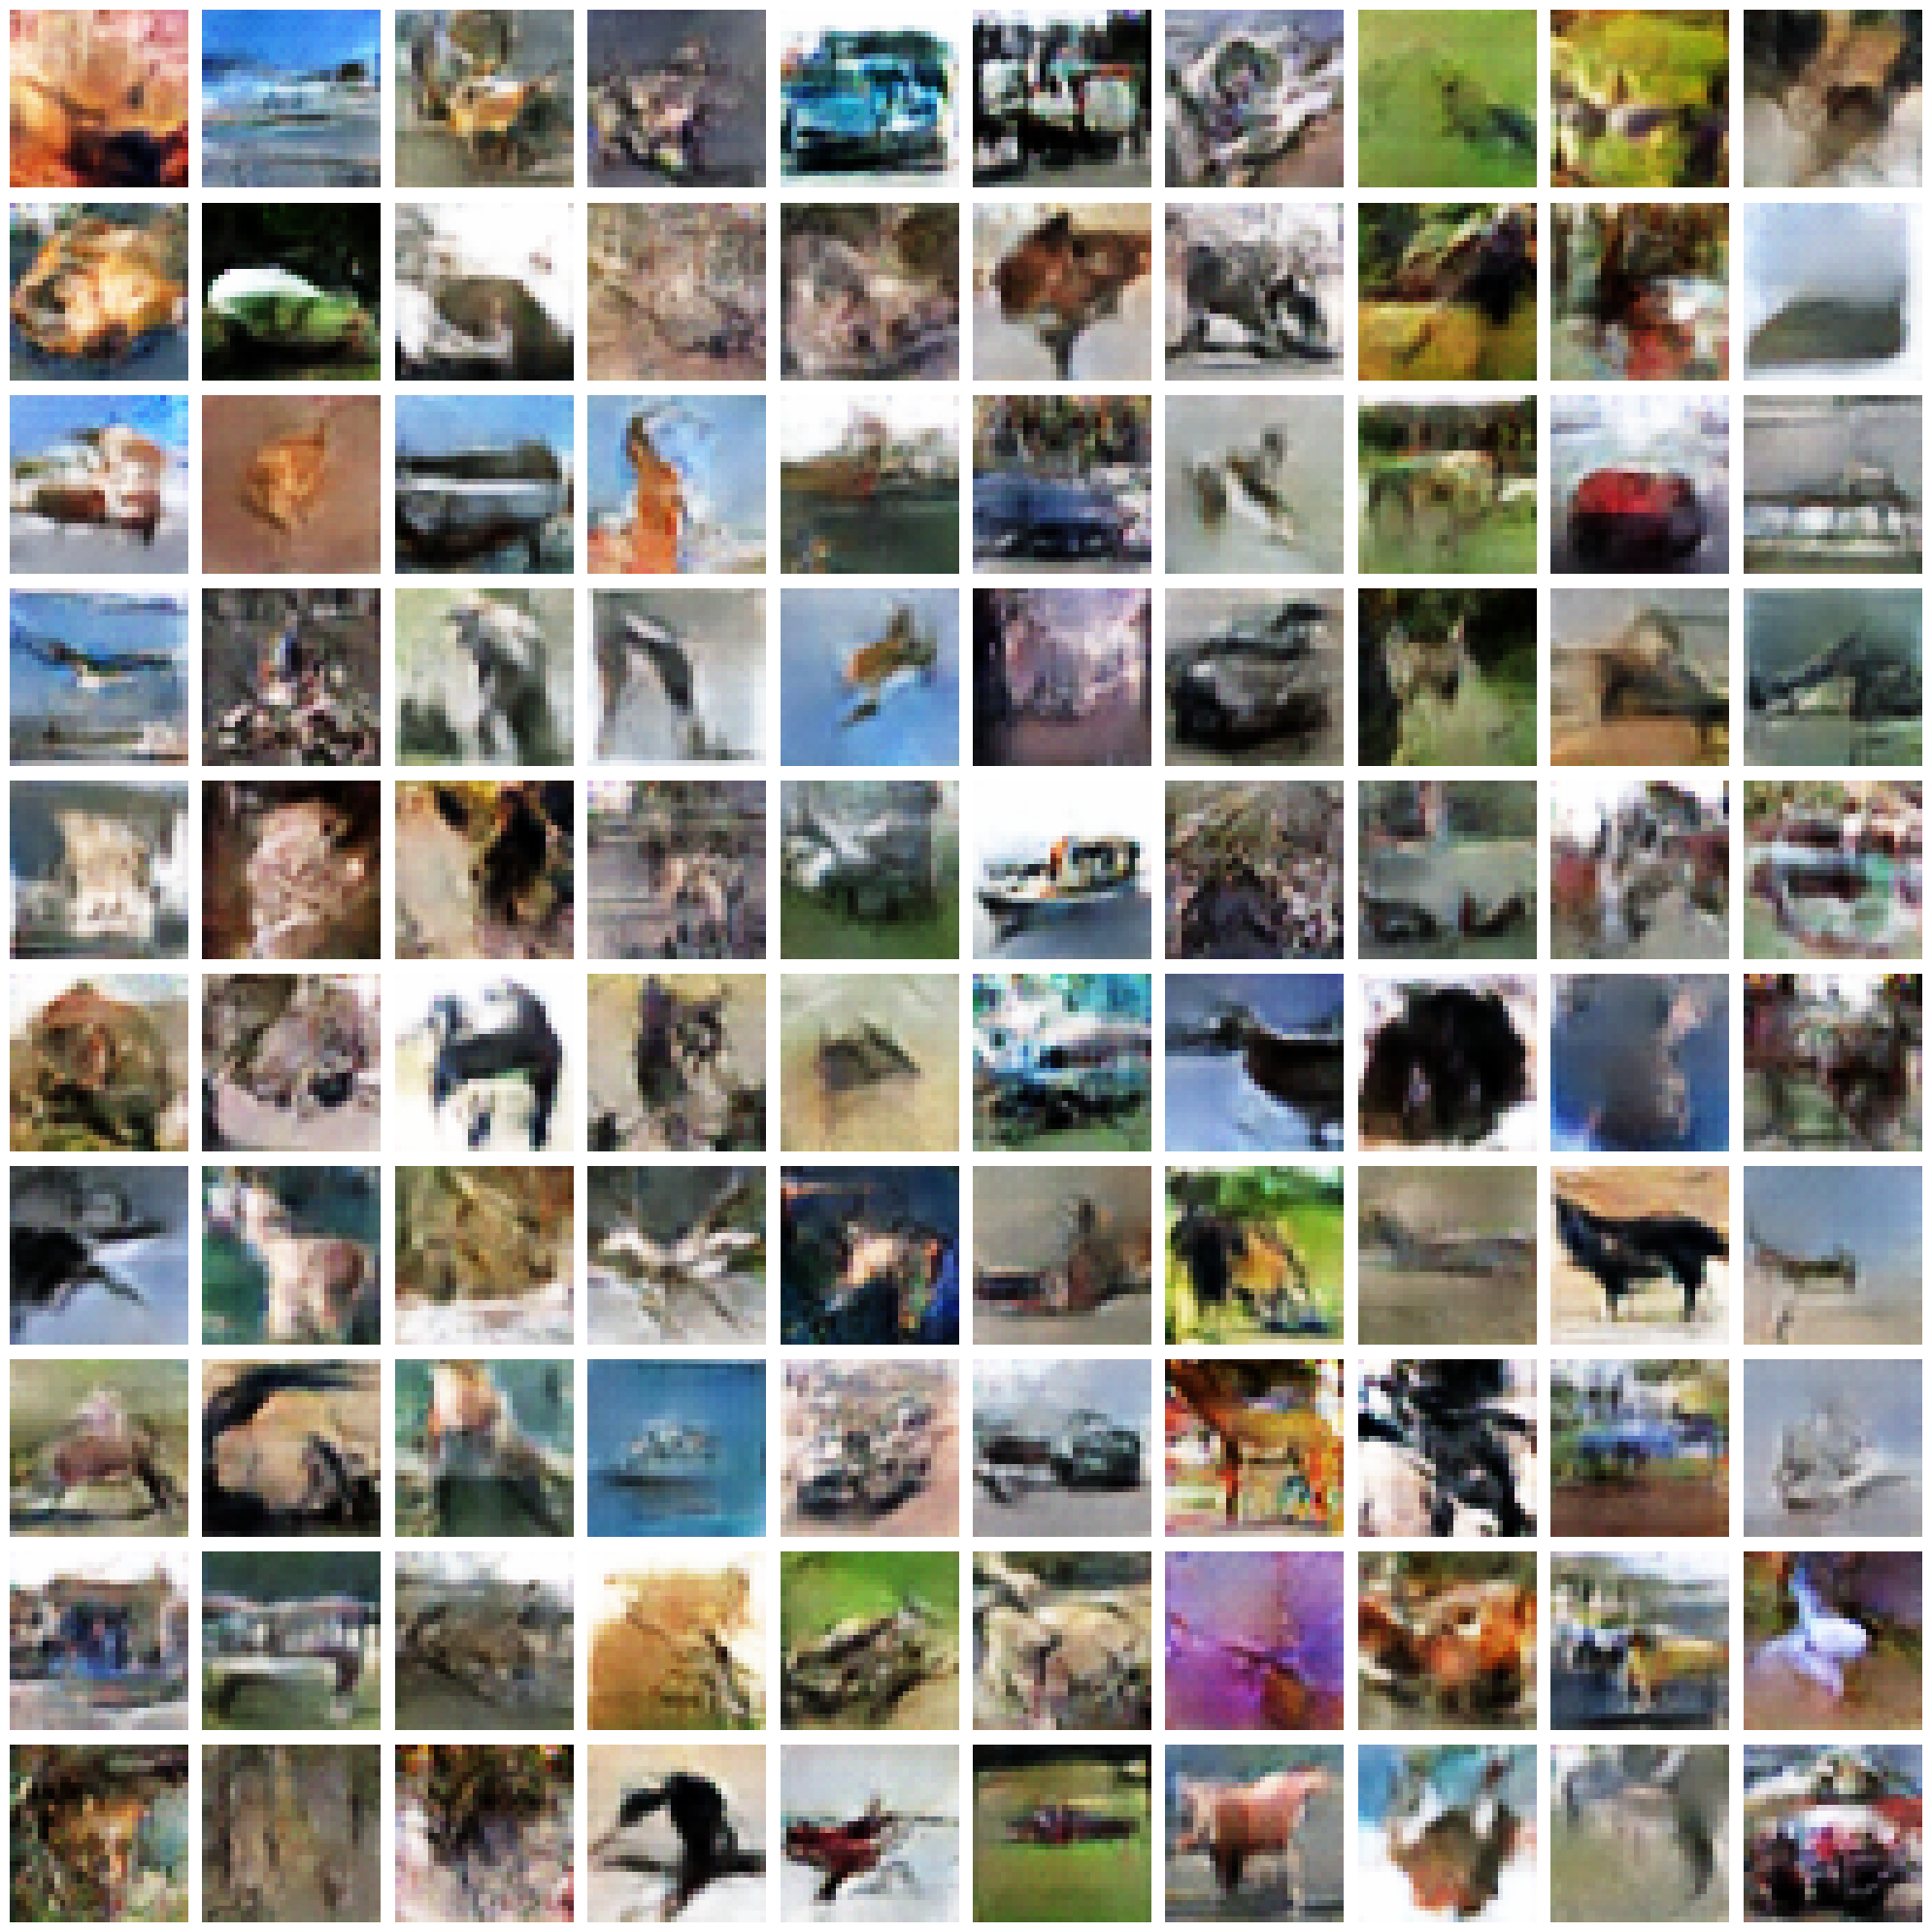

In [7]:
sample(gan_model.generator, num_samples=100, shape=(100, 1, 1), device=device, show=True)
pass

# VAE

In [7]:
import torch.nn.functional as F


class VAEModule(BaseModel):
    def __init__(self, latent_dim=128, lr=1e-3, beta=0.1):
        super().__init__()
        self.vae_model = VariationalAutoEncoder(latent_dim=latent_dim)
        self.latent_dim = latent_dim
        self.lr = lr
        self.beta = beta

        self.validation_z = torch.randn(8, latent_dim, device=self.device)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.vae_model.parameters(), lr=self.lr)
        return {"vae_optimizer": optimizer}

    @staticmethod
    def loss_function(outputs, targets, beta=0.1):
        recon_x, mu, logvar = outputs
        x = targets
        BCE = F.binary_cross_entropy(recon_x.view(-1, 3 * 32 * 32), x.view(-1, 3 * 32 * 32), reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))
        total_loss = BCE + beta * KLD
        return total_loss, BCE, KLD

    def training_step(self, batch, optimizers):
        imgs, _ = batch
        imgs = imgs.to(self.device)

        optimizer = optimizers["vae_optimizer"]

        # Forward pass
        outputs = self.vae_model(imgs)
        loss, bce, kld = self.loss_function(outputs, imgs, beta=self.beta)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return {"loss": loss.item(), "bce": bce, "kld": kld}

    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        imgs = imgs.to(self.device)

        # Forward pass
        outputs = self.vae_model(imgs)
        loss, bce, kld = self.loss_function(outputs, imgs, beta=self.beta)

        piq.ssim

        val_output = {"loss": loss.item(), "bce": bce, "kld": kld}

        if batch_idx == 0:
            reconstructed_images = torchvision.utils.make_grid(torch.cat([imgs[:8], outputs[0][:8]], dim=0))
            sampled_imaged = torchvision.utils.make_grid(self.vae_model.decode(self.validation_z))
            val_output.update({
                "reconstruction_img": reconstructed_images,
                "sampling_img": sampled_imaged
            })

        return val_output


In [8]:
vae_model = VAEModule(latent_dim=128)

vae_trainer = Trainer(
    model=vae_model,
    data_module=cifar10_data_module,
    log_dir='./tensorboard/vae_logs',
    checkpoint_dir='./tensorboard/vae_checkpoints',
    device=device)

In [9]:
vae_trainer.train(num_epochs=50)

Epoch 0:
	Train Metrics = {'loss': 119706.0721}
	Val Metrics = {'loss': 115415.70311255971}
	Best model saved at epoch 0 with loss=115415.703113
Epoch 0:
	Train Metrics = {'loss': 115570.60165}
	Val Metrics = {'loss': 114162.73743531051}
	Best model saved at epoch 1 with loss=114162.737435
Epoch 1:
	Train Metrics = {'loss': 114655.8171125}
	Val Metrics = {'loss': 113539.56273636545}
	Best model saved at epoch 2 with loss=113539.562736
Epoch 2:
	Train Metrics = {'loss': 114159.7805875}
	Val Metrics = {'loss': 112993.58485519506}
	Best model saved at epoch 3 with loss=112993.584855
Epoch 3:
	Train Metrics = {'loss': 113750.1261625}
	Val Metrics = {'loss': 112681.35572999602}
	Best model saved at epoch 4 with loss=112681.355730
Epoch 4:
	Train Metrics = {'loss': 113462.1047375}
	Val Metrics = {'loss': 112559.94225218949}
	Best model saved at epoch 5 with loss=112559.942252
Epoch 5:
	Train Metrics = {'loss': 113226.854875}
	Val Metrics = {'loss': 112369.5317227309}
	Best model saved at epo

KeyboardInterrupt: 

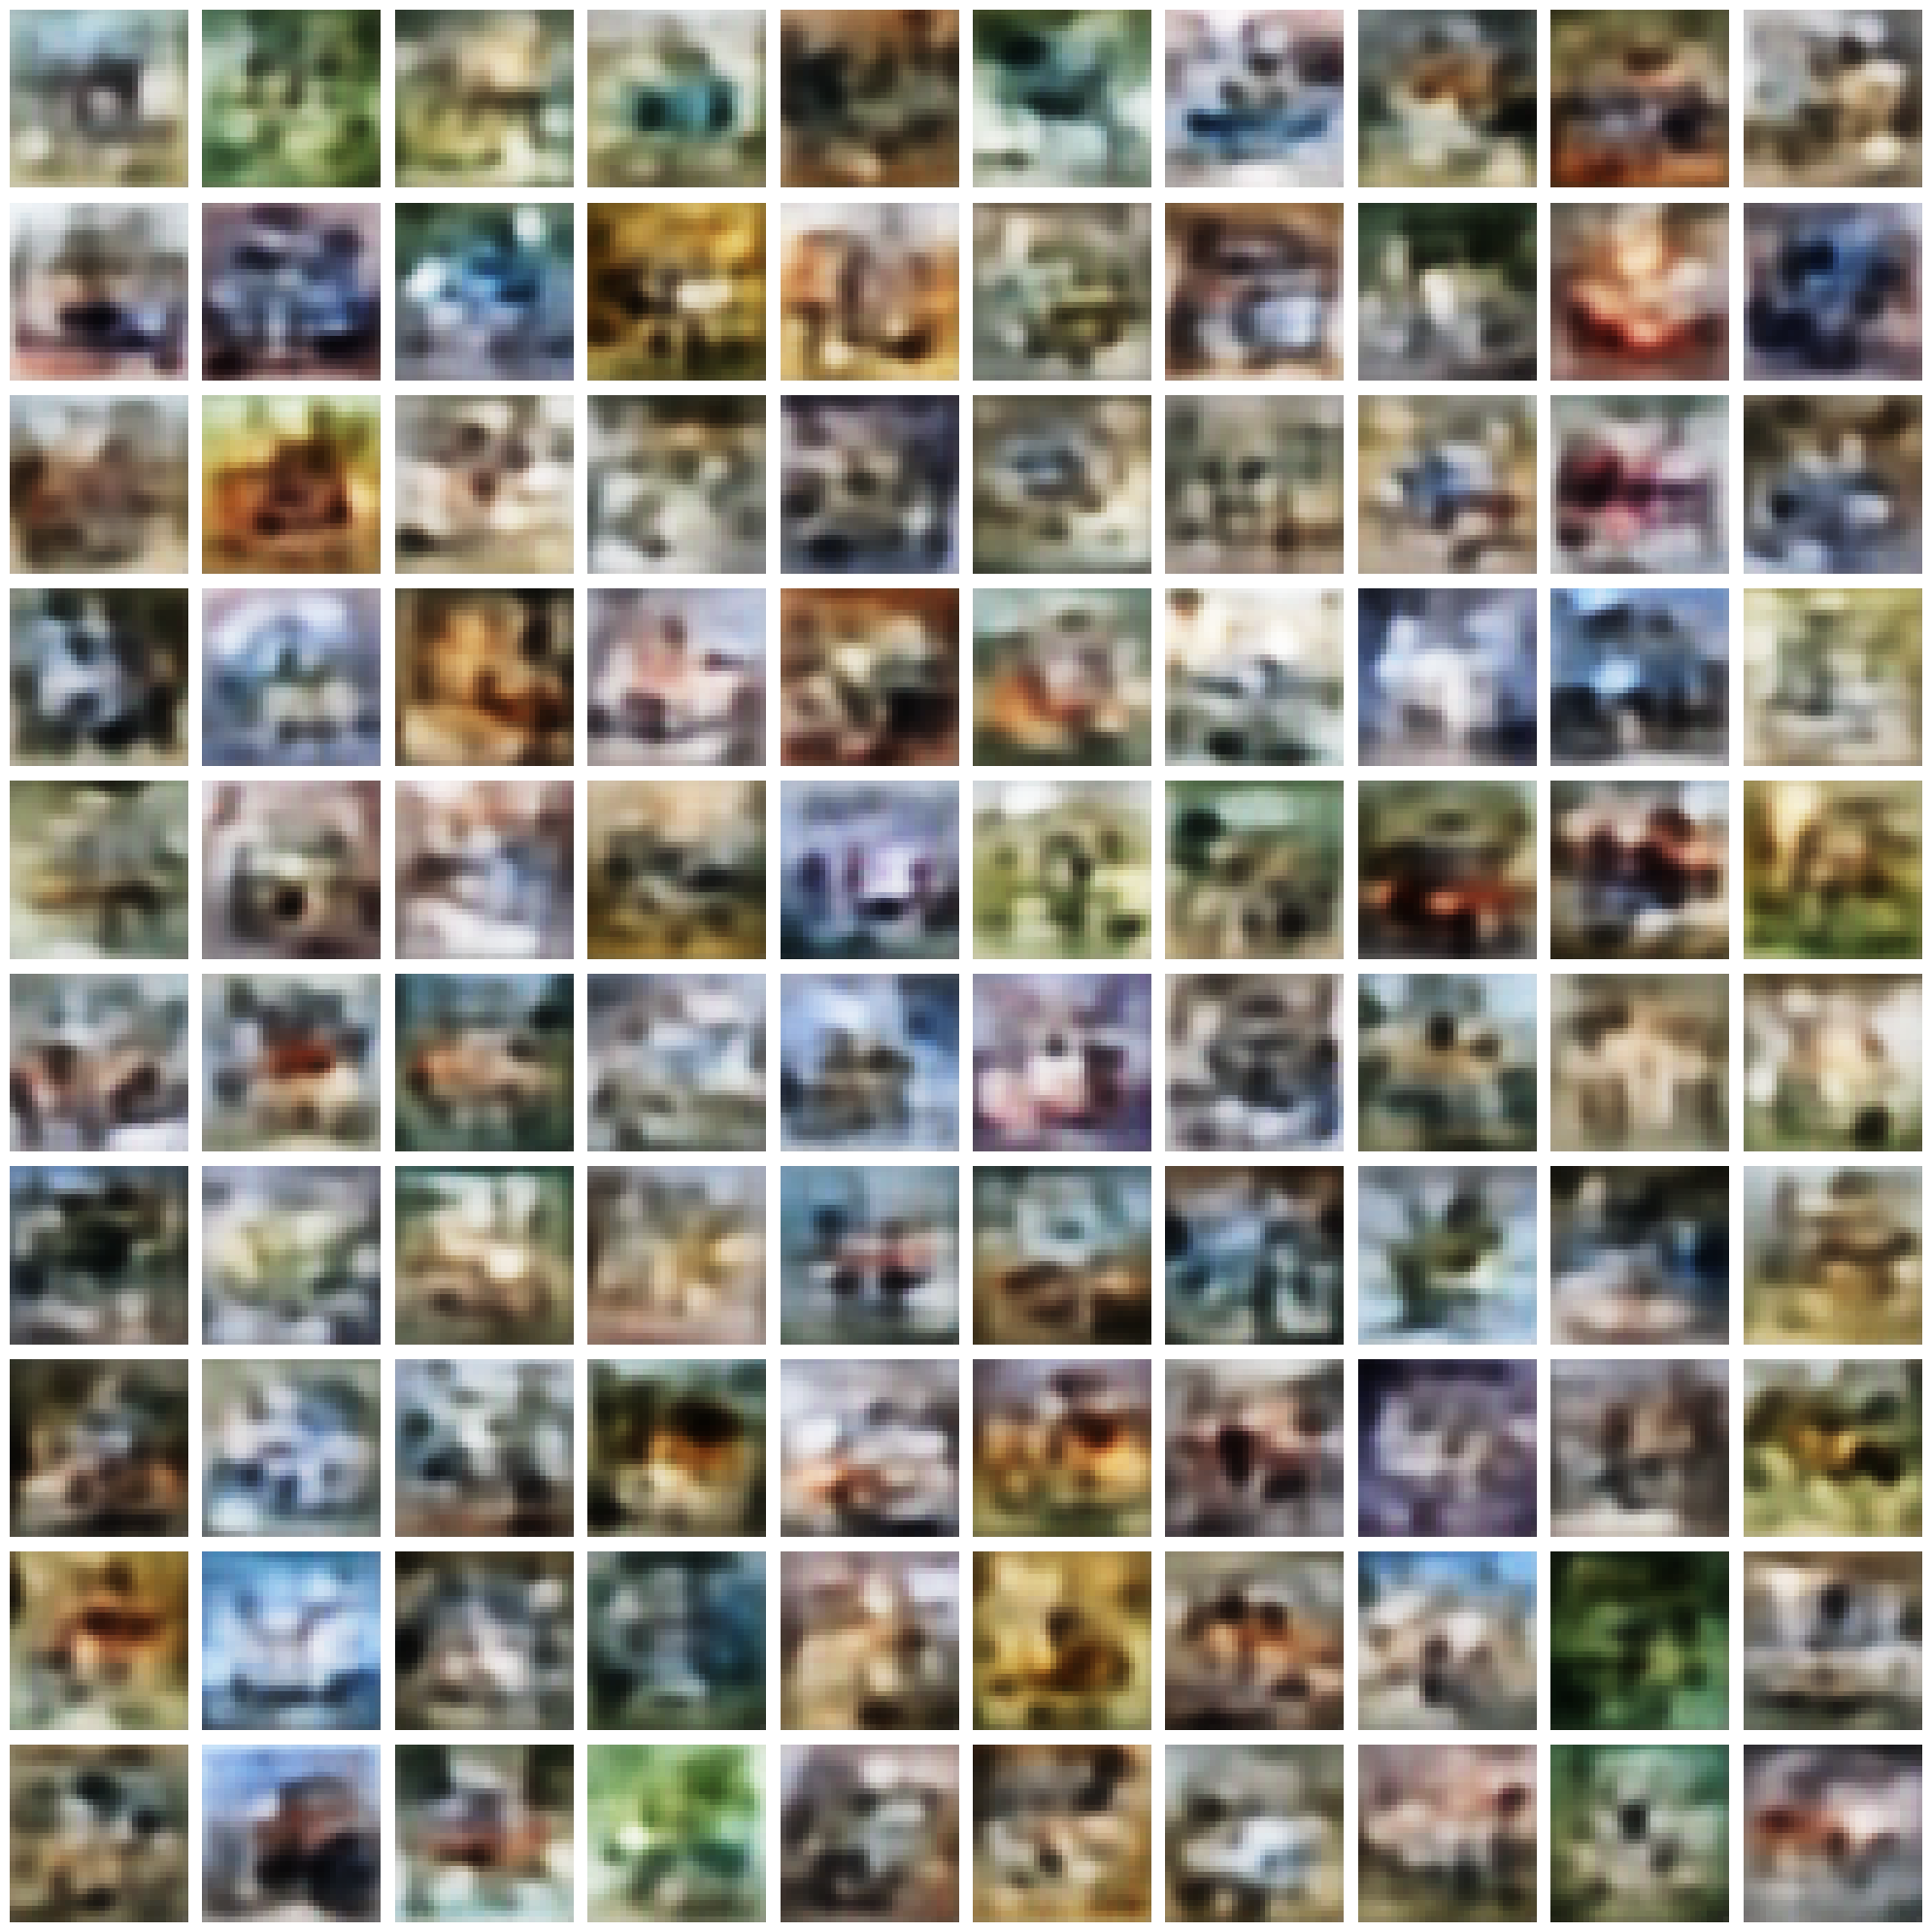

''

In [7]:
sample(vae_model.vae_model.decode, 100, shape=(128,), device=device, show=True)
_

# AE

In [14]:
class AEModule(BaseModel):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.ae_model = AutoEncoder()
        self.lr = lr
        self.loss_function = nn.MSELoss()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.ae_model.parameters(), lr=self.lr)
        return {"ae_optimizer": optimizer}

    def training_step(self, batch, optimizers):
        imgs, _ = batch
        imgs = imgs.to(self.device)

        optimizer = optimizers["ae_optimizer"]

        # Forward pass
        outputs = self.ae_model(imgs)
        loss = self.loss_function(outputs, imgs)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return {"loss": loss.item()}

    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        imgs = imgs.to(self.device)

        # Forward pass
        outputs = self.ae_model(imgs)
        loss = self.loss_function(outputs, imgs)

        val_output = {"loss": loss.item()}

        if batch_idx == 0:
            reconstructed_images = torchvision.utils.make_grid(torch.cat([imgs[:8], outputs[:8]], dim=0))
            val_output.update({
                "reconstruction_img": reconstructed_images,
            })

        return val_output


In [15]:
ae_model = AEModule(lr=5e-4)

ae_trainer = Trainer(
    model=ae_model,
    data_module=cifar10_data_module,
    log_dir='./tensorboard/ae_logs',
    checkpoint_dir='./tensorboard/ae_checkpoints',
    device=device)

In [16]:
ae_trainer.train(num_epochs=20)

Epoch 0:
	Train Metrics = {'loss': 0.022998657125234603}
	Val Metrics = {'loss': 0.012661559097943413}
	Best model saved at epoch 0 with loss=0.012662
Epoch 0:
	Train Metrics = {'loss': 0.011010135336220264}
	Val Metrics = {'loss': 0.009788866059937675}
	Best model saved at epoch 1 with loss=0.009789
Epoch 1:
	Train Metrics = {'loss': 0.008810060821473599}
	Val Metrics = {'loss': 0.008096330763570442}
	Best model saved at epoch 2 with loss=0.008096
Epoch 2:
	Train Metrics = {'loss': 0.00761710020750761}
	Val Metrics = {'loss': 0.007175135586387033}
	Best model saved at epoch 3 with loss=0.007175
Epoch 3:
	Train Metrics = {'loss': 0.006872707861661911}
	Val Metrics = {'loss': 0.006530060103625819}
	Best model saved at epoch 4 with loss=0.006530
Epoch 4:
	Train Metrics = {'loss': 0.006311516872048378}
	Val Metrics = {'loss': 0.006065843834476486}
	Best model saved at epoch 5 with loss=0.006066
Epoch 5:
	Train Metrics = {'loss': 0.005719447852671146}
	Val Metrics = {'loss': 0.005411887182

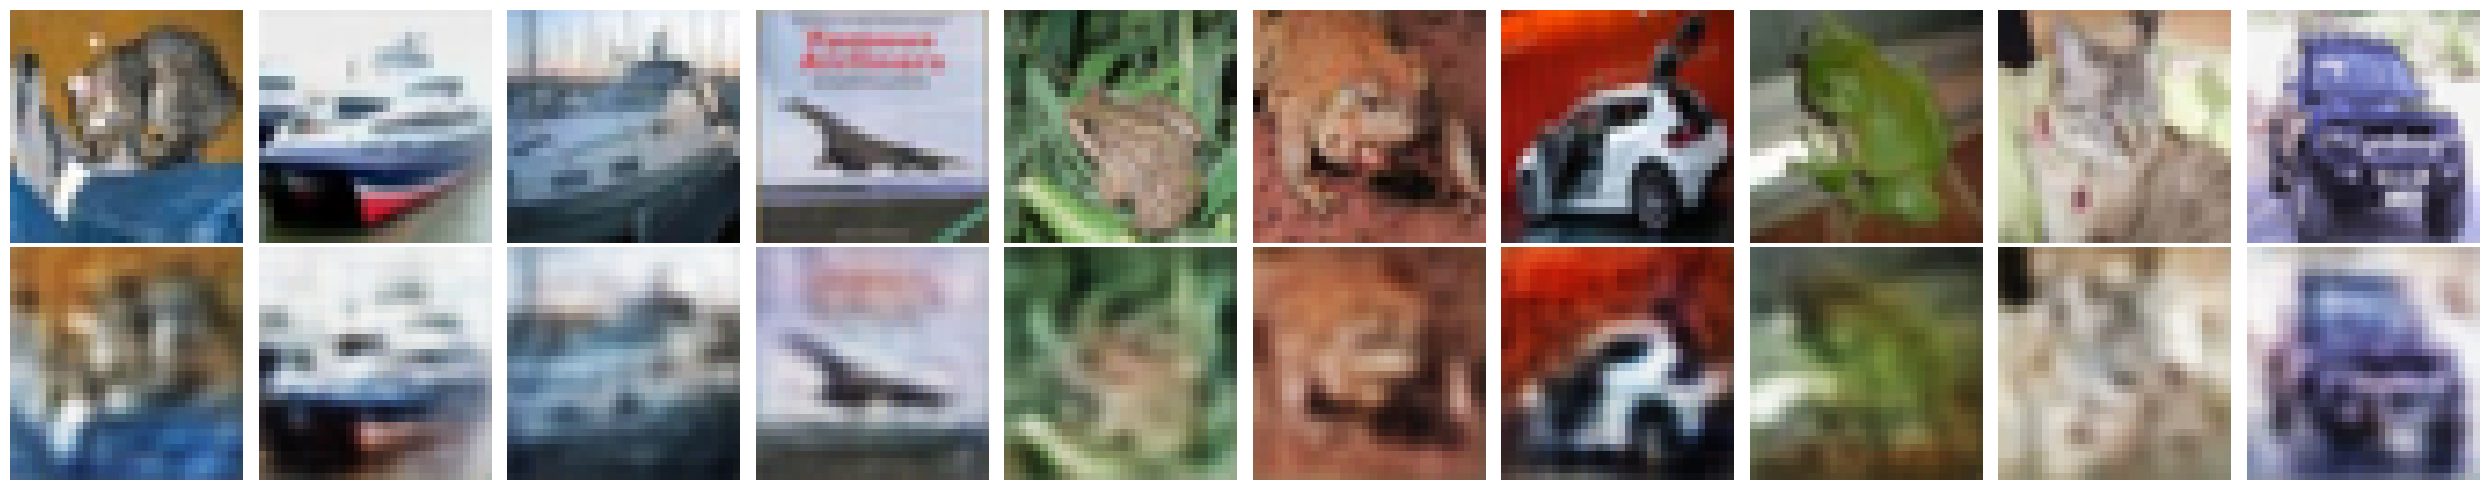

In [25]:
visualize_reconstructions(ae_model.ae_model, cifar10_data_module.test_dataloader(), device=device)

In [ ]:
'img'